# **Exp 17. Segmentation map으로 도로 이미지 만들기**

---

# **🗼목차**
Step 0. 라이브러리 불러오기  
Step 1. 데이터 불러오기  
Step 2. augmentation  
Step 3. Generator 구성하기  
Step 4. Discriminator 구성하기  
Step 5. 모델 학습하기  
🌞회고

---

# **Step 0. 라이브러리 불러오기**

In [ ]:
import numpy as np
import tensorflow
import os

# print(numpy.__version__)
# print(tensorflow.__version__)

---

# **Step 1. 데이터 불러오기**

cityscapes의 train, val 데이터를 불러오고 데이터의 수를 확인해보자.

In [ ]:
train_path = '/content/drive/MyDrive/AIFFEL/cityscapes/cityscapes/train/'
train = os.listdir(train_path)
print('train 데이터 수: ', len(train))

train 데이터 수:  1000


In [ ]:
val_path = '/content/drive/MyDrive/AIFFEL/cityscapes/cityscapes/val/'
val = os.listdir(val_path)
print('val 데이터 수 : ', len(val))

val 데이터 수 :  5


각 이미지들이 어떻게 생겼는지 확인하기 위해 train 데이터셋에서 임의로 6장을 선택하여 시각화해보자.

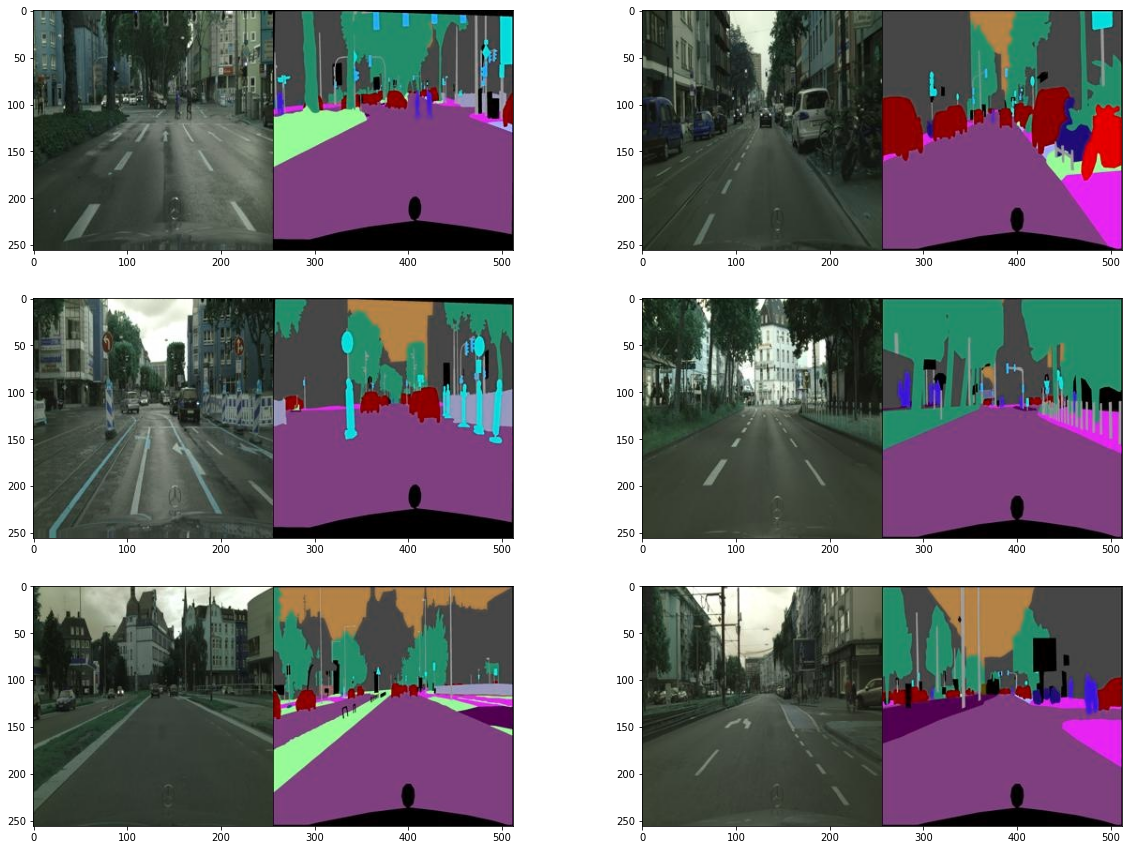

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(20,15))
for i in range(1, 7):
    f = train_path + os.listdir(train_path)[np.random.randint(800)]
    img = cv2.imread(f, cv2.IMREAD_COLOR)
    plt.subplot(3,2,i)
    plt.imshow(img)

해당 이미지의 크기를 확인해보자.

In [ ]:
f = train_path + os.listdir(train_path)[0]
img = cv2.imread(f, cv2.IMREAD_COLOR)

print(img.shape)

(256, 512, 3)


모덱 학습에 사용할 데이터를 (256, 256, 3) 크기의 2개 이미지로 분할하여 사용하고자 한다.

In [ ]:
import tensorflow as tf

def normalize(x):
    x = tf.cast(x, tf.float32)
    return (x/127.5) - 1

def denormalize(x):
    x = (x+1)*127.5
    x = x.numpy()
    return x.astype(np.uint8)

def load_img(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, 3)
    
    w = tf.shape(img)[1] // 2
    real_img = img[:, :w, :] 
    real_img = tf.cast(real_img, tf.float32)
    seg_img = img[:, w:, :] 
    seg_img = tf.cast(seg_img, tf.float32)
    return normalize(seg_img), normalize(real_img)

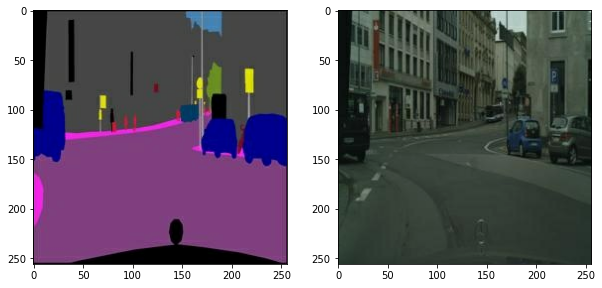

In [ ]:
f = train_path + os.listdir(train_path)[1]
seg_img, real_img = load_img(f)

plt.figure(figsize=(10,7))
plt.subplot(1,2,1); plt.imshow(denormalize(seg_img))
plt.subplot(1,2,2); plt.imshow(denormalize(real_img))

---

# **Step 2. augmentation**
- `apply_augmentation` 함수는 스케치 및 채색된 2개 이미지를 입력으로 받아 여러가지 연산을 두 이미지에 동일하게 적용한다.

In [ ]:
from tensorflow import image
from tensorflow.keras.preprocessing.image import random_rotation

@tf.function() # 빠른 텐서플로 연산을 위해 @tf.function()을 사용합니다. 
def apply_augmentation(seg_img, real_img):
    stacked = tf.concat([seg_img, real_img], axis=-1)     # 2개의 이미지가 채널 축으로 연결
    
    _pad = tf.constant([[30,30],[30,30],[0,0]])
    if tf.random.uniform(()) < .5:
        padded = tf.pad(stacked, _pad, "REFLECT")         # 50% 확률로 Refection padding이 30 픽셀의 pad width만큼 적용
    else:
        padded = tf.pad(stacked, _pad, "CONSTANT", constant_values=1.)   # 50% 확률로 constant padding이 30 픽셀의 pad width만큼 적용

    out = image.random_crop(padded, size=[256, 256, 6])   # (256, 256, 6) 크기를 가진 이미지를 임의로 자름
    
    out = image.random_flip_left_right(out)    # 50% 확률로 가로로 뒤집음
    out = image.random_flip_up_down(out)       # 50% 확률로 세로로 뒤집음
    
    if tf.random.uniform(()) < .5:
        degree = tf.random.uniform([], minval=1, maxval=4, dtype=tf.int32)
        out = image.rot90(out, k=degree)      # 50% 확률로 회전시킴
    
    return out[...,:3], out[...,3:]   

print("✅")

✅


다양한 데이터셋을 만들어 많은 이미지를 생성하면 좋은 일반화 결과를 기대할 수 있다.
### 🪐다양한 augmentation 기법 사용해보기

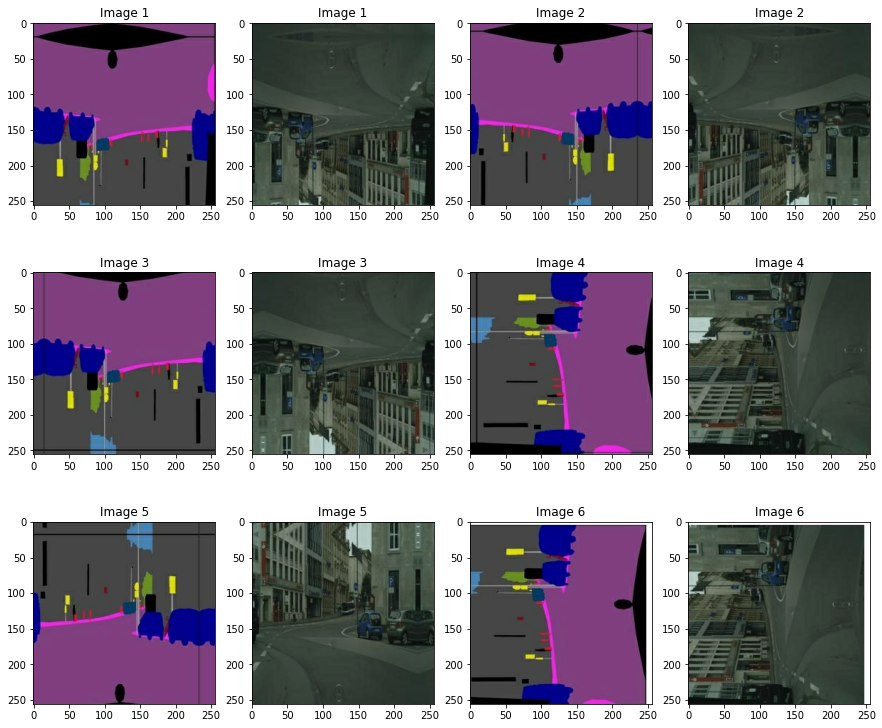

In [ ]:
plt.figure(figsize=(15,13))
img_n = 1
for i in range(1, 13, 2):
    augmented_seg_img, augmented_real_img = apply_augmentation(seg_img, real_img)
    
    plt.subplot(3,4,i)
    plt.imshow(denormalize(augmented_seg_img)); plt.title(f"Image {img_n}")
    plt.subplot(3,4,i+1); 
    plt.imshow(denormalize(augmented_real_img)); plt.title(f"Image {img_n}")
    img_n += 1

위의 과정들을 train 데이터에 적용하며 잘 적용되었는지 하나의 이미지만 시각화하여 확인해보자.

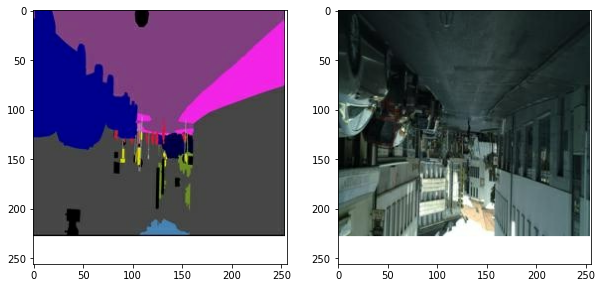

In [ ]:
from tensorflow import data

def get_train(img_path):
    seg_img, real_img = load_img(img_path)
    seg_img, real_img = apply_augmentation(seg_img, real_img)
    return seg_img, real_img

train_images = data.Dataset.list_files(train_path + "*.jpg")
train_images = train_images.map(get_train).shuffle(100).batch(4)

sample = train_images.take(1)
sample = list(sample.as_numpy_iterator())
seg_img, real_img = (sample[0][0]+1)*127.5, (sample[0][1]+1)*127.5

plt.figure(figsize=(10,5))
plt.subplot(1,2,1); plt.imshow(seg_img[0].astype(np.uint8))
plt.subplot(1,2,2); plt.imshow(real_img[0].astype(np.uint8))

---

# **💡Pix2Pix**
- 기존 노이즈 입력을 이미지로 변환하는 일반적인 GAN이 아닌, 이미지를 입력으로 하여 원하는 다른 형태의 이미지로 변환시킬 수 있는 GAN 모델이다.
- Image-to-Image Translation
- 이미지 변환이 목적이기에 이미지를 다루는데 효율적인 convolution 레이어를 활용한다.
- GAN 구조를 기반으로 하기에 크게 `Generator`과 `Discriminator` 두 가지 구성 요소로 이루어진다.

---

# **Step 3. Generator 구성하기**

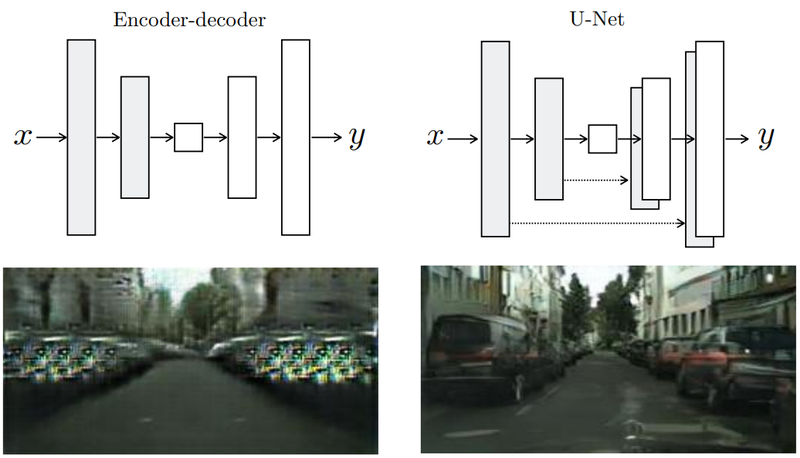

- Encoder와 Decoder 사이의 `skip connection`으로 연결한 `U-net구조`를 사용한 결과가 훨씬 더 실제 이미지에 가까운 품질을 보인다.
- `U-net구조`로 Generator를 구성해보자.

In [ ]:
from tensorflow.keras import layers, Input, Model

class EncodeBlock(layers.Layer):
    def __init__(self, n_filters, use_bn=True):
        super(EncodeBlock, self).__init__()
        self.use_bn = use_bn       
        self.conv = layers.Conv2D(n_filters, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.lrelu = layers.LeakyReLU(0.2)

    def call(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.batchnorm(x)
        return self.lrelu(x)

    
class DecodeBlock(layers.Layer):
    def __init__(self, f, dropout=True):
        super(DecodeBlock, self).__init__()
        self.dropout = dropout
        self.Transconv = layers.Conv2DTranspose(f, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.relu = layers.ReLU()
        
    def call(self, x):
        x = self.Transconv(x)
        x = self.batchnorm(x)
        if self.dropout:
            x = layers.Dropout(.5)(x)
        return self.relu(x)
    
print("✅")

✅


정의된 블록들을 이용해 한번에 `U-Net Generator`를 정의해보자.
- `__init__()`에서 정의된 `encoder_blocks`와 `decoder_blocks`가 `call()` 내부에 차례대로 사용되어 Encoder와 Decoder 내부 연산을 수행한다.
- Encoder와 Decoder 사이의 skip connection을 위해 features라는 리스트를 만든다.
- Encoder의 최종 출력이 Decoder의 입력으로 들어가면서 Decoder 블록들을 통과한다.
- features 리스트에 있는 각각의 출력들이 Decoder 블록 연산 후 함께 연결되어 다음 블록의 입력으로 사용된다.

In [ ]:
class UNetGenerator(Model):
    def __init__(self):            # __init__ 메서드에서 Encoder와 Decoder에서 사용할 모든 블록들을 정의
        super(UNetGenerator, self).__init__()
        encode_filters = [64,128,256,512,512,512,512,512]
        decode_filters = [512,512,512,512,256,128,64]
        
        self.encode_blocks = []
        for i, f in enumerate(encode_filters):
            if i == 0:
                self.encode_blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.encode_blocks.append(EncodeBlock(f))
        
        self.decode_blocks = []
        for i, f in enumerate(decode_filters):
            if i < 3:
                self.decode_blocks.append(DecodeBlock(f))
            else:
                self.decode_blocks.append(DecodeBlock(f, dropout=False))
        
        self.last_conv = layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False)
    
    def call(self, x):                 # call에서 forward propagation하도록 함
        features = []
        for block in self.encode_blocks:
            x = block(x)
            features.append(x)
        
        features = features[:-1]       # Encoder의 마지막 출력은 Decoder에 직접 입력되므로 skip connection의 대상이 아님
                    
        for block, feat in zip(self.decode_blocks, features[::-1]):   # Encoder와 Decoder가 대칭을 이루며 연결되기에 features의 역순으로 연결함
            x = block(x)
            x = layers.Concatenate()([x, feat])
        
        x = self.last_conv(x)
        return x
                
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

print("✅")

✅


In [ ]:
UNetGenerator().get_summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 encode_block_24 (EncodeBlock)  (None, 128, 128, 64  3072        ['input_5[0][0]']                
                                )                                                                 
                                                                                                  
 encode_block_25 (EncodeBlock)  (None, 64, 64, 128)  131584      ['encode_block_24[0][0]']        
                                                                                            

- U-Net Generator에서 사용한 skip-connection으로 인해 Decoder의 각 블록에서 입력받는 채널 수가 늘어났다.
- 이에 따라 블록 내 convolution layer에서 사용하는 필터의 크기가 커지면서 학습해야 할 파라미터가 늘어났다.

---

# **Step 4. Discriminator 구성하기**
좀 더 사실적인 이미지를 생성하기 위한 Pix2Pix를 완성시키기 위해서는 Discriminator가 필요하다.

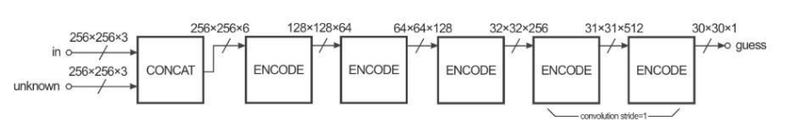

* Discriminator는 2개의 입력을 받아 연결(CONCAT)한 후, `ENCODE` 블록 5개를 통과한다.
* 그 중 마지막 블록은 1차원 출력을 위해 추가되었다.
    
    
* 최종적으로 출력되는 크기는 (30, 30, 1)이다.
* 출력 이전의 2개 블록을 보면 출력 크기가 1씩 감소하는 것을 알 수 있다.
    
    
* 최종 출력 크기가 (30, 30, 1)이 되어야 하는 이유는 70x70 PatchGAN을 사용했기 때문이다.
* 최종 (30, 30) 출력에서 각 픽셀의 receptive field 크기를 (70, 70)으로 맞추기 위해 Discriminator 출력 크기를 (30, 30) 크기로 강제로 맞추는 과정이다.

In [ ]:
class DiscBlock(layers.Layer):
    def __init__(self, n_filters, stride=2, custom_pad=False, use_bn=True, act=True):
        super(DiscBlock, self).__init__()
        self.custom_pad = custom_pad
        self.use_bn = use_bn
        self.act = act
        
        if custom_pad:
            self.padding = layers.ZeroPadding2D()
            self.conv = layers.Conv2D(n_filters, 4, stride, "valid", use_bias=False)
        else:
            self.conv = layers.Conv2D(n_filters, 4, stride, "same", use_bias=False)
        
        self.batchnorm = layers.BatchNormalization() if use_bn else None
        self.lrelu = layers.LeakyReLU(0.2) if act else None
        
    def call(self, x):
        if self.custom_pad:
            x = self.padding(x)
            x = self.conv(x)
        else:
            x = self.conv(x)
                
        if self.use_bn:
            x = self.batchnorm(x)
            
        if self.act:
            x = self.lrelu(x)
        return x 

print("✅")

✅


아래와 같은 코드 설정으로 (width, height) 크기를 1씩 감소시킬 수 있다.

In [ ]:
inputs = Input((128,128,32))
out = layers.ZeroPadding2D()(inputs)
out = layers.Conv2D(64, 4, 1, "valid", use_bias=False)(out)
out = layers.BatchNormalization()(out)
out = layers.LeakyReLU(0.2)(out)

Model(inputs, out).summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 128, 128, 32)]    0         
                                                                 
 zero_padding2d_9 (ZeroPaddi  (None, 130, 130, 32)     0         
 ng2D)                                                           
                                                                 
 conv2d_53 (Conv2D)          (None, 127, 127, 64)      32768     
                                                                 
 batch_normalization_73 (Bat  (None, 127, 127, 64)     256       
 chNormalization)                                                
                                                                 
 leaky_re_lu_49 (LeakyReLU)  (None, 127, 127, 64)      0         
                                                                 
Total params: 33,024
Trainable params: 32,896
Non-trainable

- 첫 번째 블록은 단순한 연결(concat)을 수행한다.
- Discriminator의 최종 출력은 `sigmoid`활성화를 사용하였다.

In [ ]:
class Discriminator(Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.block1 = layers.Concatenate()
        self.block2 = DiscBlock(n_filters=64, stride=2, custom_pad=False, use_bn=False, act=True)
        self.block3 = DiscBlock(n_filters=128, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block4 = DiscBlock(n_filters=256, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block5 = DiscBlock(n_filters=512, stride=1, custom_pad=True, use_bn=True, act=True)
        self.block6 = DiscBlock(n_filters=1, stride=1, custom_pad=True, use_bn=False, act=False)
        self.sigmoid = layers.Activation("sigmoid")
        
        # filters = [64,128,256,512,1]
        # self.blocks = [layers.Concatenate()]
        # for i, f in enumerate(filters):
        #     self.blocks.append(DiscBlock(
        #         n_filters=f,
        #         strides=2 if i<3 else 1,
        #         custom_pad=False if i<3 else True,
        #         use_bn=False if i==0 and i==4 else True,
        #         act=True if i<4 else False
        #     ))
    
    def call(self, x, y):
        out = self.block1([x, y])
        out = self.block2(out)
        out = self.block3(out)
        out = self.block4(out)
        out = self.block5(out)
        out = self.block6(out)
        return self.sigmoid(out)
    
    def get_summary(self, x_shape=(256,256,3), y_shape=(256,256,3)):
        x, y = Input(x_shape), Input(y_shape) 
        return Model((x, y), self.call(x, y)).summary()
    
print("✅")

✅


In [ ]:
Discriminator().get_summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_8 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 concatenate_53 (Concatenate)   (None, 256, 256, 6)  0           ['input_7[0][0]',                
                                                                  'input_8[0][0]']          

(256, 256, 3) 크기의 입력을 넣어 나오는 (30, 30) 출력을 시각화해보자.

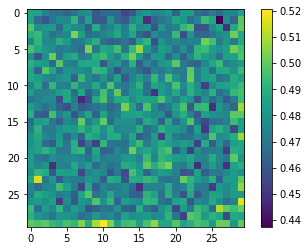

In [ ]:
x = tf.random.normal([1,256,256,3])
y = tf.random.uniform([1,256,256,3])

disc_out = Discriminator()(x, y)
plt.imshow(disc_out[0, ... ,0])
plt.colorbar()

---

# **Step 5. 모델 학습하기**

## **5.1 손실함수 정의**
- 일반적인 GAN의 손실함수에 L1을 추가로 이용했을 때 가장 실제에 가까운 이미지를 생성해냈다. 
- 이번 프로젝트에서도 2가지 손실함수를 모두 사용해보자.

#### Generator 손실함수 (get_gene_loss)
* `fake_disc`는 Generator가 생성한 가짜 이미지를 Discriminator에 입력하여 얻어진 값이며 실제 이미지를 뜻하는 1과 비교하기 위해 `tf.ones_like()`를 사용한다.
* L1 손실을 계산하기 위해 생성한 가짜 이미지(`fake_output`)와 실제 이미지(`real_output`) 사이의 MAE(Mean Absolute Error)를 계산한다.

#### Discriminator 손실함수 (get_disc_loss)
* `fake_disc`, `real_disc`는 가짜 및 진짜 이미지가 Discriminator에 각각 입력되어 얻어진 값
* Discriminator는 실제 이미지를 잘 구분해내야 하므로 `real_disc`는 1로 채워진 백터와 비교, `fake_disc`는 0으로 채워진 벡터와 비교한다.

In [ ]:
from tensorflow.keras import losses

bce = losses.BinaryCrossentropy(from_logits=False)
mae = losses.MeanAbsoluteError()

def get_gene_loss(fake_output, real_output, fake_disc):
    l1_loss = mae(real_output, fake_output)
    gene_loss = bce(tf.ones_like(fake_disc), fake_disc)
    return gene_loss, l1_loss

def get_disc_loss(fake_disc, real_disc):
    return bce(tf.zeros_like(fake_disc), fake_disc) + bce(tf.ones_like(real_disc), real_disc)

print("✅")

✅


## **5.2 optimizer 설정**
- 논문과 동일하게 optimizer를 설정한다.

In [ ]:
from tensorflow.keras import optimizers

gene_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)
disc_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)

print("✅")

✅


## **5.3 가중치 업데이트 과정**
- 하나의 배치 크기만큼 데이터를 입력했을 때, 가중치를 1회 업데이트하는 과정을 구현해보자.
* 최종 Generator 손실을 계산할 때, 손실에 100을 곱하였다. 
* `λ`는 학습 과정에서 L1손실을 얼마나 반영할 것인지 나타낸다.
* 논문에서는 `λ = 100`을 사용하였다.

In [ ]:
@tf.function
def train_step(sketch, real_colored):
    with tf.GradientTape() as gene_tape, tf.GradientTape() as disc_tape:
        # Generator 예측
        fake_colored = generator(sketch, training=True)
        # Discriminator 예측
        fake_disc = discriminator(sketch, fake_colored, training=True)
        real_disc = discriminator(sketch, real_colored, training=True)
        # Generator 손실 계산
        gene_loss, l1_loss = get_gene_loss(fake_colored, real_colored, fake_disc)
        gene_total_loss = gene_loss + (100 * l1_loss) ## <===== L1 손실 반영 λ=100
        # Discrminator 손실 계산
        disc_loss = get_disc_loss(fake_disc, real_disc)
                
    gene_gradient = gene_tape.gradient(gene_total_loss, generator.trainable_variables)
    disc_gradient = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    gene_opt.apply_gradients(zip(gene_gradient, generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_gradient, discriminator.trainable_variables))
    return gene_loss, l1_loss, disc_loss

print("✅")

✅


## **5.4 모델 학습**
- 원래 10 에포크 이상 돌려야 하는데, 시간 관계 상 5 에포크만 돌렸다.

In [ ]:
EPOCHS = 5

generator = UNetGenerator()
discriminator = Discriminator()

for epoch in range(1, EPOCHS+1):
    for i, (seg_img, real_img) in enumerate(train_images):
        g_loss, l1_loss, d_loss = train_step(seg_img, real_img)
                
        # 100회 반복마다 손실을 출력합니다.
        if (i+1) % 100 == 0:
            print(f"EPOCH[{epoch}] - STEP[{i+1}] \
                    \nGenerator_loss:{g_loss.numpy():.4f} \
                    \nL1_loss:{l1_loss.numpy():.4f} \
                    \nDiscriminator_loss:{d_loss.numpy():.4f}", end="\n\n")

EPOCH[1] - STEP[100]                     
Generator_loss:1.1805                     
L1_loss:0.1673                     
Discriminator_loss:1.0373

EPOCH[1] - STEP[200]                     
Generator_loss:1.1661                     
L1_loss:0.1818                     
Discriminator_loss:0.6998

EPOCH[2] - STEP[100]                     
Generator_loss:1.0659                     
L1_loss:0.1791                     
Discriminator_loss:0.6092

EPOCH[2] - STEP[200]                     
Generator_loss:0.7749                     
L1_loss:0.1956                     
Discriminator_loss:0.8747

EPOCH[3] - STEP[100]                     
Generator_loss:1.9353                     
L1_loss:0.1821                     
Discriminator_loss:0.5199

EPOCH[3] - STEP[200]                     
Generator_loss:1.5287                     
L1_loss:0.1771                     
Discriminator_loss:0.5025

EPOCH[4] - STEP[100]                     
Generator_loss:2.4698                     
L1_loss:0.2030             

- 1개의 스케치 이미지, 생성된 이미지, 실제 이미지를 시각화해보자.
- 에포크를 적게 돌려서인지 흐릿하게만 출력된 것을 확인할 수 있다.

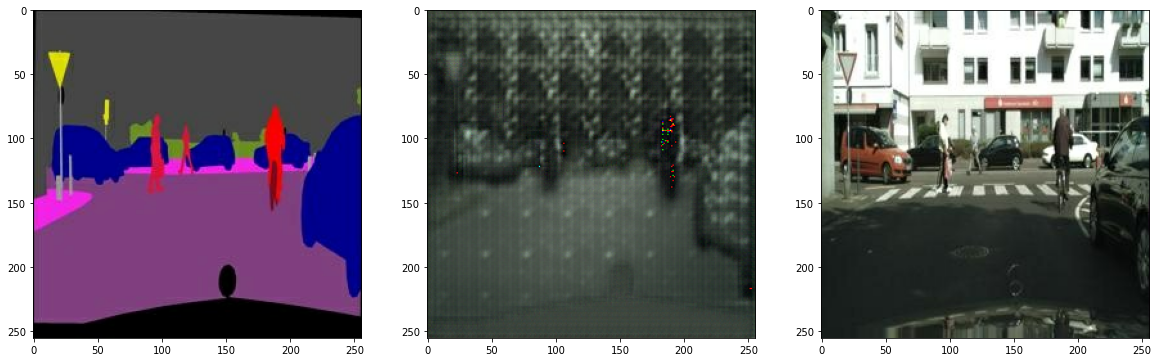

In [ ]:
test_ind = 1

f = val_path + os.listdir(val_path)[test_ind]
seg_img, real_img = load_img(f)

pred = generator(tf.expand_dims(seg_img, 0))
pred = denormalize(pred)

plt.figure(figsize=(20,10))
plt.subplot(1,3,1); plt.imshow(denormalize(seg_img))
plt.subplot(1,3,2); plt.imshow(pred[0])
plt.subplot(1,3,3); plt.imshow(denormalize(real_img))

---

# **🌞회고**

- 이번 프로젝트는 가장 신경을 못 쓴 프로젝트이다....ㅠㅠ 마무리를 잘하고 싶었으나 이런저런 상황들로 결국은 급하게 해서 결국은 에포크도 10 이상 돌리지 못하고 끝났다....
- 노이즈가 아닌 이미지를 입력으로 해서 이미지를 출력하는 Pix2Pix가 매우 흥미로웠는데, 다양한 시도를 하지 못해서 아쉬웠다.

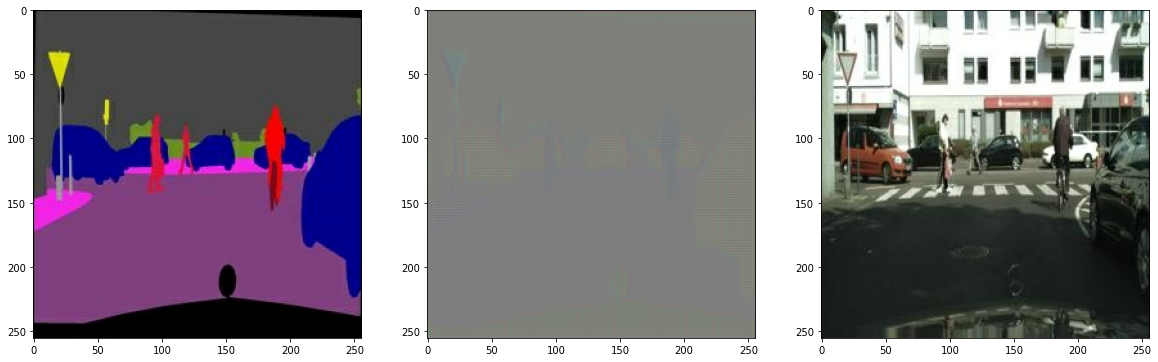

- 생각보다 에포크를 돌리는데 오래 걸려서 초반에 당황했다가 에포크를 매우 낮춘 후 결국 10으로만 돌렸었다.
- 하지만 위와 같은 이미지가 출력이 된 것을 보고 에포크의 횟수 문제인 줄 알았으나 다시 코드를 일일이 확인해봤더니 코드에 작은 실수가 있었다.
- 코드를 다시 수정하였으나 시간이 부족해 결국 에포크 5만 들렸고, 그 결과 회고 위의 결과를 얻게 되었다.
- 에포크를 많이 돌려도 큰 차이가 없다고 다들 말하셨지만, 난 에포크를 단지 5만 돌린 상황이라 그 이상 돌렸더라면 그래도 좀 더 선명한 이미지가 나오지 않았을까라는 생각이 든다.
- 그래도 코드를 수정해서 이 결과라도 얻어서 다행이다...!
- 처음으로 코랩으로 프로젝트를 진행해보았다. 처음이라 다소 낯설긴 했지만 하다보니 조금씩 적응이 되는 것 같다!